# SB 827 Analysis
## September 2018 re-work

<h2> to do: </h2>
<ol>
    <li><s> fix interpolator </s></li>
    <li><s>add functionality to deal with different service_ids </s></li>
    <li><s>deal with different modes in one system</s></li>
</ol>

### prologue

In [2]:
import pandas as pd, numpy as np, time, datetime, csv, os
from matplotlib import pyplot as plt

In [46]:
'''# path for log CSV
filename = "output/log.csv"

# CSV writer
ll = open(filename, 'w')
writer = csv.writer(ll)
writer.writerow(["agency", "timestamp", "num_stops", "ghost_stops", "interpolated", "5", "4", "3", "2", "1", "0"])
ll.close()'''

'# path for log CSV\nfilename = "output/log.csv"\n\n# CSV writer\nll = open(filename, \'w\')\nwriter = csv.writer(ll)\nwriter.writerow(["agency", "timestamp", "num_stops", "ghost_stops", "interpolated", "5", "4", "3", "2", "1", "0"])\nll.close()'

In [129]:
# specify agency
#path = 'gtfs/sfmta--60/'

In [491]:
# specify agency
list_of_agencies = list(os.walk('gtfs'))[0][1]

path = "gtfs/" + list_of_agencies[np.random.randint(0, len(list_of_agencies))] + "/"
path

'gtfs/modesto-area-express--417/'

In [492]:
print(path)
print("-------")

agency_name = pd.read_csv(path + 'agency.txt')['agency_name'][0]
agency_name = agency_name.replace("/","-")
print(agency_name)

trips = pd.read_csv(path + 'trips.txt')
print(len(trips), "trips")

routes = pd.read_csv(path + 'routes.txt')
print(len(routes), "routes")

stops = pd.read_csv(path + 'stops.txt')
print(len(stops), "stops")

stop_times = pd.read_csv(path + 'stop_times.txt')
print(len(stop_times), "stop times")

calendar = pd.read_csv(path + "calendar.txt")
print(len(calendar), "schedules")

calendar_dates = pd.read_csv(path + "calendar_dates.txt")
print(len(calendar_dates), "exception dates")

gtfs/modesto-area-express--417/
-------
Modesto Area Express
1377 trips
19 routes
824 stops
41330 stop times
3 schedules
3 exception dates


In [493]:
trips2directions = dict(zip(trips['trip_id'], trips['direction_id']))
trips2service = dict(zip(trips['trip_id'], trips['service_id']))
trips2routes = dict(zip(trips['trip_id'], trips['route_id']))
routes2headsigns = dict(zip(routes['route_id'], routes['route_short_name']))
routes2route_type = dict(zip(routes['route_id'], routes['route_type']))

In [494]:
def minSinceMidnight(t):
    if type(t) == str:
        tt = t.split(':')
        msm = (int(tt[0])*60) + int(tt[1]) + (int(tt[2])/60)
    else:
        msm = t
    return msm

In [495]:
## REWROTE on 9/20 TO DEAL WITH DUPLICATE TIMES

def interpolator(trip):
    
    lsst = list(stop_times[stop_times['trip_id'] == trip]['arrival_time'])
    lsst = [minSinceMidnight(x) for x in lsst]
    
    last_scheduled_time = lsst[0]
    lst_index = 0
    
    values = [last_scheduled_time]
    
    for x in range(1,len(lsst)):
        #print(x)
        if pd.isnull(lsst[x]) == False:
            #idx = lsst.index(x)
            #print(idx)
            yy = list(np.linspace(last_scheduled_time, lsst[x], num=(x-lst_index+1)))

            values += yy[1:]
            last_scheduled_time = lsst[x]
            lst_index = x
        else:
            pass
    return values # returns linear interpolation of times

<h2> interpolation </h2>

In [496]:
did_i_interp = False

#agency_trips = list(trips['trip_id'].unique())
# changed agency_trips definition to preserve order of trips
agency_trips = list(stop_times.drop_duplicates('trip_id')['trip_id'])

if (sum(pd.isnull(stop_times['arrival_time']))/len(stop_times)) > 0.05:
    allInterpolatedTimes = []

    intrS = time.time()
    for trip in agency_trips:
        allInterpolatedTimes += interpolator(trip)
    intrF = time.time()
    
    did_i_interp = True
    print("interpolated " + str(len(agency_trips)), "trips ("+ str(len(stop_times))+" vehicle stops) in", str(intrF - intrS), "seconds")
else:
    allInterpolatedTimes = [minSinceMidnight(x) for x in stop_times['arrival_time']]
    print("did not interpolate")

interpolated 1377 trips (41330 vehicle stops) in 7.862301826477051 seconds


In [497]:
useStrings = False # variable to decide if we need to use string versions of route_id or integer

if type(trips['trip_id'][0]) != str:
    stop_times['interpolated'] = allInterpolatedTimes
    stop_times['direction_id'] = [trips2directions[x] for x in stop_times['trip_id']]
    stop_times['service_id'] = [trips2service[x] for x in stop_times['trip_id']]
    stop_times['route_type'] = [routes2route_type[trips2routes[x]] for x in stop_times['trip_id']]
else:
    stop_times['interpolated'] = allInterpolatedTimes
    stop_times['direction_id'] = [trips2directions[str(x)] for x in stop_times['trip_id']]
    stop_times['service_id'] = [trips2service[str(x)] for x in stop_times['trip_id']]
    stop_times['route_type'] = [routes2route_type[trips2routes[str(x)]] for x in stop_times['trip_id']]
    useStrings = True
    
# deal with routes that don't have directions specified
stop_times['direction_id'] = [0 if pd.isnull(x) == True else x for x in list(stop_times['direction_id'])]

## service_id identification

In [498]:
# create dictionary object with exceptions dates for different types of service

exceptions = {}

for x in range(len(calendar_dates)):
    exception_date = str(calendar_dates['date'][x])
    exception_service_id = calendar_dates['service_id'][x]
    exception_type = calendar_dates['exception_type'][x]
    
    if exception_date not in exceptions:
        exceptions[exception_date] = {1:[],2:[]}
        exceptions[exception_date][exception_type].append(exception_service_id)
    else:
        exceptions[exception_date][exception_type].append(exception_service_id)

In [499]:
days_of_week = {0:"monday", 1:"tuesday", 2:"wednesday", 3:"thursday", 4:"friday", 5:"saturday", 6:"sunday"}

In [500]:
# GENERATES service_ids IN USE ON SPECIFIED DAY OF WEEK
# ALSO ENSURES THAT SCHEDULES ARE ACTIVE DURING SPECIFIED TIME FRAME

weekday = "20180918"
saturday = "20180922"
sunday = "20180923"

weekday_day = days_of_week[datetime.datetime(int(weekday[:4]), int(weekday[4:6]), int(weekday[6:])).weekday()]
saturday_day = days_of_week[datetime.datetime(int(saturday[:4]), int(saturday[4:6]), int(saturday[6:])).weekday()]
sunday_day = days_of_week[datetime.datetime(int(sunday[:4]), int(sunday[4:6]), int(sunday[6:])).weekday()]

# this if-else statement checks to make sure that calendar.txt file is up to date
# if none of the service_id are currently active, we take them anyway
# otherwise, we filter out any inactive service_id

if len([x for x in list(calendar['end_date']) if x > np.min([int(weekday), int(saturday), int(sunday)])]) == 0:
    weekday_query = "(%s == 1) & (%s >= start_date)" % (weekday_day, weekday)
    saturday_query = "(%s == 1) & (%s >= start_date)" % (saturday_day, saturday)
    sunday_query = "(%s == 1) & (%s >= start_date)" % (sunday_day, sunday)
else:
    weekday_query = "(%s == 1) & (%s >= start_date) & (%s <= end_date)" % (weekday_day, weekday, weekday)
    saturday_query = "(%s == 1) & (%s >= start_date) & (%s <= end_date)" % (saturday_day, saturday, saturday)
    sunday_query = "(%s == 1) & (%s >= start_date) & (%s <= end_date)" % (sunday_day, sunday, sunday)

weekday_service = list(calendar.query(weekday_query)['service_id'])
saturday_service = list(calendar.query(saturday_query)['service_id'])
sunday_service = list(calendar.query(sunday_query)['service_id'])


## mode differentiation

In [501]:
bus_types = [3]
rail_types = [0,1,2]
ferry_types = [4]

In [502]:
# queries to filter by various time criteria
# strings for pd.DF.query

am_peak_query = "interpolated >= 360 and interpolated <= 600"
pm_peak_query = "interpolated >= 900 and interpolated <= 1140"
weekday_range_query = "interpolated >= 360 and interpolated <= 1320"
saturday_range_query = "interpolated >= 480 and interpolated <= 1320"
sunday_range_query = "interpolated >= 480 and interpolated <= 1320"

In [503]:
# defines the schema for the dict object holding headways

dataHolderSpec = {
                  "name":'',
                  "longitude":np.NaN,
                  "latitude":np.NaN,
                0: {
                    "served_by": [],
                    "AM Peak": np.NaN,
                    "PM Peak": np.NaN,
                    "Weekdays": np.NaN,
                    "Saturday": np.NaN,
                    "Sunday": np.NaN
                     },
                 1: {
                    "served_by": [],
                    "AM Peak": np.NaN,
                    "PM Peak": np.NaN,
                    "Weekdays": np.NaN,
                    "Saturday": np.NaN,
                    "Sunday": np.NaN
                     }
                 }

In [504]:
# create dictionary object to hold information about stops
# dictionary will be used for quick access

stops_data = {}

for i in range(len(stops)):
    stop_id = stops['stop_id'][i]
    stop_name = stops['stop_name'][i]
    stop_lon = stops['stop_lon'][i]
    stop_lat = stops['stop_lat'][i]
    
    stops_data[stop_id] = {
        "name": stop_name,
        "lon": stop_lon,
        "lat": stop_lat
    }

### required fields for output:
<ol>
    <li>agency</li> 
    <li>stop id</li>
    <li>stop name</li>
    <li>stop x</li>
    <li>stop y</li>
    <li>am peak headway (IB)</li>
    <li>pm peak headway (IB)</li>
    <li>weekday headway (IB)</li>
    <li>saturday headway (IB)</li>
    <li>sunday headway (IB)</li>
    <li>am peak headway (OB)</li>
    <li>pm peak headway (OB)</li>
    <li>weekday headway (OB)</li>
    <li>saturday headway (OB)</li>
    <li>sunday headway (OB)</li>
</ol>

<p><i> The CSV output for each agency should have the above attributes as unique fields. </i></p>

## output generation

In [506]:
# make sure directory for saving outputs exists
if os.path.isdir("output") == False:
    os.mkdir("output")
else:
    pass

timeS = time.time() # start time, for evaluation

# establish dates to evaluate, currently set up to do just one date per type
# dates expressed in YYYYMMDD
weekday = "20180918"
saturday = "20180922"
sunday = "20180923"

# path for output CSV
filename = "output/%s_test.csv" % agency_name

# split up stops by transit mode
bus_stops = stop_times[stop_times['route_type'].isin(bus_types)].reset_index()
rail_stops = stop_times[stop_times['route_type'].isin(rail_types)].reset_index()
ferry_stops = stop_times[stop_times['route_type'].isin(ferry_types)].reset_index()

if len(bus_stops) > 1:
    # CSV writer
    f = open(filename, 'w')
    writer = csv.writer(f)
    writer.writerow(["Stop ID", "Name", "Agency", "X", "Y", "OB Routes", "OB AM Peak", "OB PM Peak", "OB Weekday", "OB Saturday", "OB Sunday", "IB Routes", "IB AM Peak", "IB PM Peak", "IB Weekday", "IB Saturday", "IB Sunday"])

    # ordered list of different time windows to evaluate
    filter_options = ['AM Peak', "PM Peak", 'Weekdays', 'Saturday', 'Sunday']


    # the following lists are in the same order as filter_options, so indices would be common across lists
    # e.g. filter_options[0] is "AM Peak" and filters[0] is am_peak_query, and filter_sched[0] is the weekday schedule, etc.
    # this feels kind of messy and we may want to play with cleaning this up
    filters = [am_peak_query, pm_peak_query, weekday_range_query, saturday_range_query, sunday_range_query]
    filter_sched = [0,0,0,1,2] # index of service_id in schedules array
    filter_time_per = [4,4,16,14,14] # number of hours in each evaluative window
    filter_crit = [16,16,48,28,28] # number of required buses during evaluative window
    filter_services = [weekday_service, weekday_service, weekday_service, saturday_service, sunday_service]
    filter_day = [weekday, weekday, weekday, saturday, sunday]

    # list of unique stops in that transit system
    unique_stops = bus_stops['stop_id'].unique()

    # number of stops to evaluate
    # to run for the entire agency, set num_of_stops = len(unique_stops)
    num_of_stops = len(unique_stops)
    updater = "%s has %s unique bus stops." % (agency_name, num_of_stops)
    print(updater)

    #CHECK THIS OUT
    for stop in unique_stops[:num_of_stops]:
        # stop characteristics

        if agency_name == "AC Transit":
            # add a "0" to stop_ids because AC Transit stores stop_ids as seven-character strings
            # this will need to be made flexible when this is reworked to accomodate other agencies
            if len(str(stop)) < 7:
                stringstop = "0" + str(stop)
            else:
                stringstop = str(stop)
        else:
            stringstop = stop

        try:
            sub_stops_data = stops_data[stringstop] # subset of larger dictionary to make data storage syntax cleaner
        except KeyError:
            sub_stops_data = stops_data[str(stringstop)]
        # use defined dictionary variable from previous cell and populate with name and location info from stops DF
        dataHolder = dataHolderSpec 
        dataHolder['name'] = sub_stops_data['name']
        dataHolder['longitude'] = sub_stops_data['lon']
        dataHolder['latitude'] = sub_stops_data['lat']

        for direction in [0,1]: # iterate through both directions
            # create a DF that contains one stop in one direction
            # ex. stop_id 300315, direction_id  0
            tempDF = bus_stops[(bus_stops['stop_id'] == stop) & (bus_stops['direction_id'] == direction)]

            # generate a list of all the short names for the routes that stop at the defined stop in the defined direction 
            if useStrings == False:
                served_by = [str(x) for x in list(set([routes2headsigns[trips2routes[x]] for x in  tempDF['trip_id']]))]
            else:
                served_by = [str(x) for x in list(set([routes2headsigns[trips2routes[str(x)]] for x in  tempDF['trip_id']]))]

            if len(served_by) == sum(pd.isnull(served_by)):
                served_by == ['']
            else:
                pass

            #print()
            #print(stop, sub_stops_data['name'], served_by, "-", direction)


            for option in filter_options:

                i = filter_options.index(option) # list index for that time window
                fltr = filters[i]
                #fltr_sched = schedules[filter_sched[i]]
                try:
                    relevent_schedules = [x for x in filter_services[i] if x not in exceptions[filter_day[i]][2]] + exceptions[filter_day[i]][1]
                except KeyError:
                    relevent_schedules = filter_services[i]

                # integer for the number of buses that stop at a given stop in a given direction 
                # during the time period defined by the query expression
                #num_buses = len(tempDF[tempDF['service_id'] == fltr_sched].query(fltr))
                num_buses = len(tempDF[tempDF['service_id'].isin(relevent_schedules)].query(fltr).drop_duplicates(subset="arrival_time"))

                # right now, headway calculation doesn't work when service doesn't run for the entirety of the evaluative window
                # ex. AC TRANSIT stop 300315, line 65 ends at 6:30pm on weekends (does not run until 10pm)


                # crudely calculate average headway by dividing the total number of minutes during the defined time period
                # by the number of buses that stopped during that time period (num_buses)
                try:
                    headway = round(((filter_time_per[i] * 60) / num_buses), 2)
                except ZeroDivisionError:
                    headway = np.NAN
                try:
                    if pd.isnull(served_by[0]) == False:
                        dataHolder[direction]['served_by'] = served_by
                    else:
                        dataHolder[direction]['served_by'] = ['']
                except IndexError:
                    dataHolder[direction]['served_by'] = ['']
                dataHolder[direction][filter_options[i]] = headway

                #print(filter_options[i] + ": " + str(num_buses) + " of " + str(filter_crit[i]) + " required. (" + str(headway) + " min headway)")

        ob = dataHolder[0] # subset of larger dictionary (just outbound) to make data storage syntax cleaner
        ib = dataHolder[1] # subset of larger dictionary (just inbound) to make data storage syntax cleaner

        # write data to CSV
        row_contents = [str(stop), dataHolder['name'], agency_name, dataHolder['longitude'], dataHolder['latitude'], ', '.join(ob['served_by']), ob['AM Peak'], ob['PM Peak'], ob['Weekdays'], ob['Saturday'], ob['Sunday'], ', '.join(ib['served_by']), ib['AM Peak'], ib['PM Peak'], ib['Weekdays'], ib['Saturday'], ib['Sunday']]
        writer.writerow(row_contents)
    timeF = time.time() # finish time, for evaluation
    f.close()

    print()  
    # print duration of process, number of stops, and rate
    try:
        print(str(round((timeF - timeS),2)), "seconds //", str(num_of_stops), "stops //", str(round((round((timeF - timeS),2)/num_of_stops),4)), "seconds per stop")
    except ZeroDivisionError:
        pass
else:
    pass

# create rail CSV
if len(rail_stops) > 0:
    print(agency_name, "has", str(len(rail_stops['stop_id'].unique())), "rail stops.")
    railfile = "output/%s_RAIL_test.csv" % agency_name
    g = open(railfile, 'w')
    writer = csv.writer(g)
    writer.writerow(["Stop ID", "Name", "Agency", "X", "Y"])
    for stop in rail_stops['stop_id'].unique():
        writer.writerow([stop, stops_data[stop]['name'], agency_name, stops_data[stop]['lon'], stops_data[stop]['lat']])
    g.close()
else:
    pass



# create ferry CSV
if len(ferry_stops) > 0:
    print(agency_name, "has", str(len(ferry_stops['stop_id'].unique())), "ferry stops.")
    ferryfile = "output/%s_FERRY_test.csv" % agency_name
    g = open(ferryfile, 'w')
    writer = csv.writer(g)
    writer.writerow(["Stop ID", "Name", "Agency", "X", "Y"])
    for stop in ferry_stops['stop_id'].unique():
        writer.writerow([stop, stops_data[stop]['name'], agency_name, stops_data[stop]['lon'], stops_data[stop]['lat']])
    g.close()
else:
    pass

Modesto Area Express has 689 unique bus stops.

46.43 seconds // 689 stops // 0.0674 seconds per stop


## output evaluation

In [507]:
# way to evaluate output for GHOST STOPS (nan all the way through)
# ghosts stops are likely served by trips with different service_IDs so we aren't seeing them


output_path = 'output/%s_test.csv' % agency_name
ghost_path = 'output/%s_ghosts.csv' % agency_name

output = pd.read_csv(output_path) # read in output data as a new Pandas DF

output.head()

ghost_stops = output[(np.isnan(output['OB Weekday']) == True) & (np.isnan(output['OB Saturday']) == True) & (np.isnan(output['OB Sunday']) == True) &  (np.isnan(output['IB Weekday']) == True) & (np.isnan(output['IB Saturday']) == True) & (np.isnan(output['IB Sunday']) == True)][['Stop ID', 'Name', 'X', 'Y']].reset_index()

ghost_stops.to_csv(ghost_path)

pct_ghost = round((len(ghost_stops)/len(output)), 3) * 100

# capture info about ghost_stops
ghost_stop_ids = ghost_stops['Stop ID']
ghost_stop_times = stop_times[stop_times['stop_id'].isin(ghost_stop_ids)][['trip_id', 'arrival_time', 'stop_id', 'stop_sequence', 'interpolated', 'direction_id', 'service_id']].reset_index()

print(str(pct_ghost) + "% ghost stops")


0.0% ghost stops


### visualizing

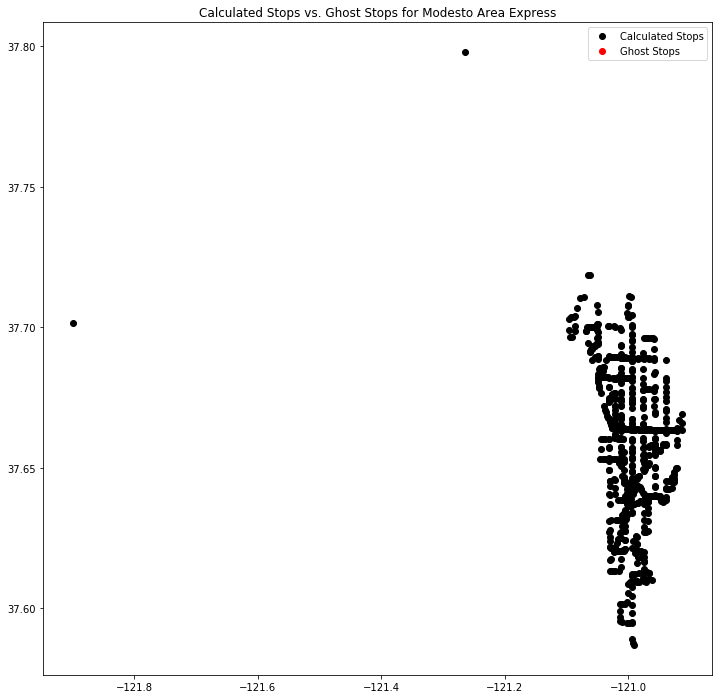

In [508]:
# visualize ghost stops

plot_title = "Calculated Stops vs. Ghost Stops for %s" % agency_name 

plt.clf()
plt.figure(figsize=(12,12))

plt.plot(output['X'], output['Y'], 'ok')
plt.plot(ghost_stops['X'], ghost_stops['Y'], 'or')


plt.legend(["Calculated Stops", "Ghost Stops"])
plt.title(plot_title)
plt.show()

In [509]:
headway_requirements = {"AM Peak": 15,"PM Peak": 15,"Weekday": 20,"Saturday": 30,"Sunday":30}

##########################################
Modesto Area Express has 689 stops
##########################################


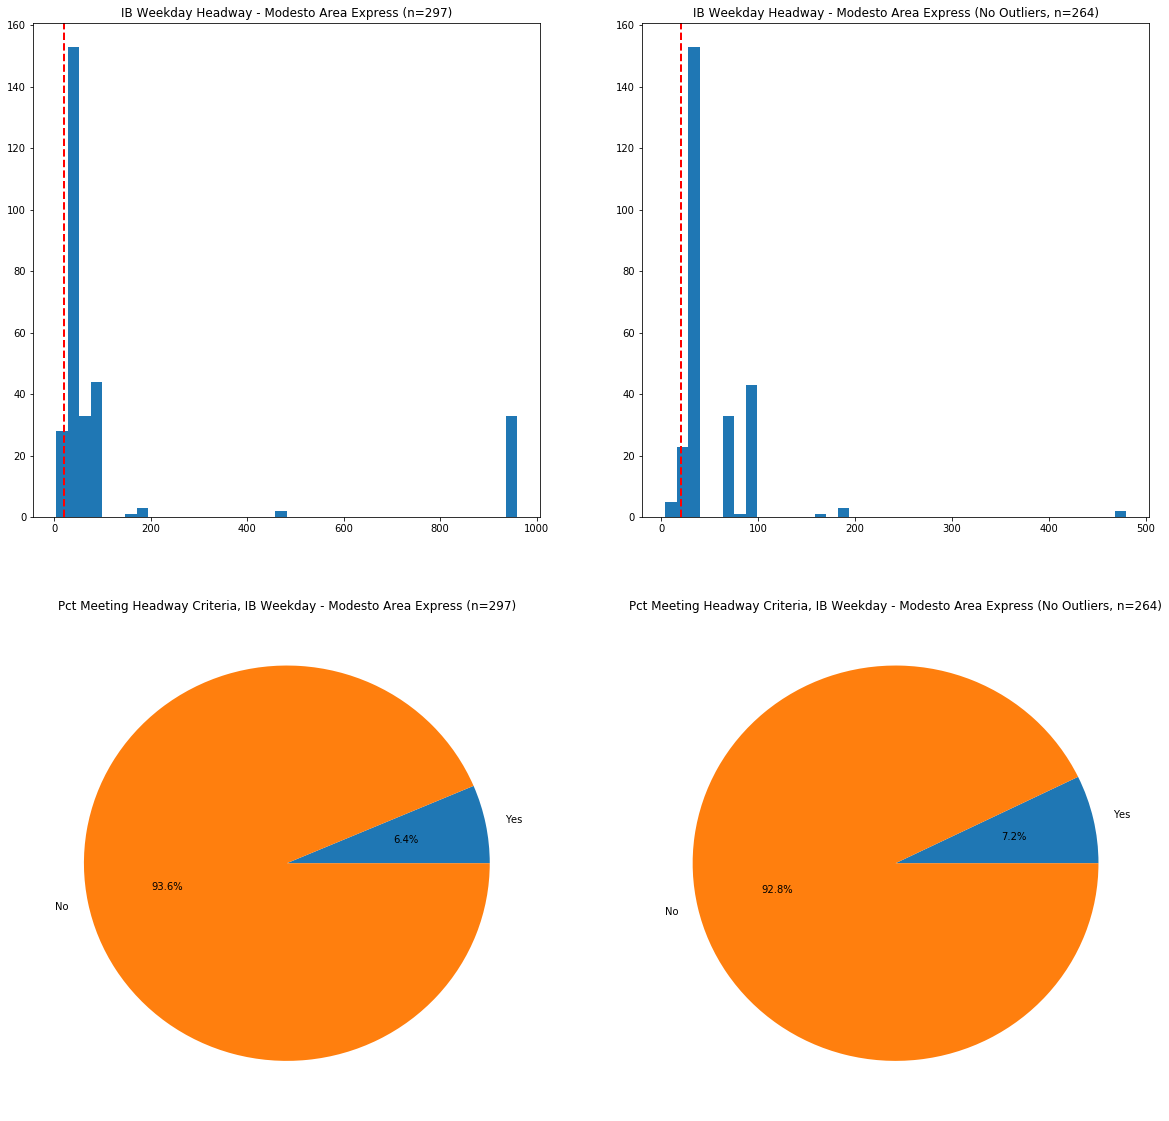

In [510]:
preliminary_message = "%s has %s stops" % (agency_name, num_of_stops)
print("##########################################")
print(preliminary_message)
print("##########################################")


plt.clf()
plt.figure(figsize=(20,20))

field = 'IB Weekday'

stddev = np.std(output[(np.isnan(output[field]) == False)][field])
mean = np.mean(output[(np.isnan(output[field]) == False)][field])

results = output[(np.isnan(output[field]) == False)][field]
results_no_outliers = output[(np.isnan(output[field]) == False) & (output[field] < (mean + (2*stddev)))][field]

# histogram
plt.subplot(221)
plt.hist(results, bins=40)
plt.axvline(x=headway_requirements[field[3:]], color='r', linestyle='dashed', linewidth=2)

chart_title = "%s Headway - %s (n=%s)" % (field, agency_name, len(results))
plt.title(chart_title)

# histogram (no outliers)
plt.subplot(222)
plt.hist(results_no_outliers, bins=40)
plt.axvline(x=headway_requirements[field[3:]], color='r', linestyle='dashed', linewidth=2)

chart_title = "%s Headway - %s (No Outliers, n=%s)" % (field, agency_name, len(results_no_outliers))
plt.title(chart_title)


# pie chart
plt.subplot(223)

met = [x for x in results if x <=  headway_requirements[field[3:]]]
try:
    pct_yes = len(met) / len(results)
except ZeroDivisionError:
    pct_yes = 0
pct_no = 1 - pct_yes

plt.pie([pct_yes, pct_no], labels=['Yes', 'No'], autopct='%1.1f%%')
chart_title2 = "Pct Meeting Headway Criteria, %s - %s (n=%s)" % (field, agency_name, len(results))
plt.title(chart_title2)

# pie chart (no outliers)
plt.subplot(224)

met = [x for x in results_no_outliers if x <=  headway_requirements[field[3:]]]
try:
    pct_yes = len(met) / len(results_no_outliers)
except ZeroDivisionError:
    pct_yes = 0
pct_no = 1 - pct_yes

plt.pie([pct_yes, pct_no], labels=['Yes', 'No'], autopct='%1.1f%%')
chart_title2 = "Pct Meeting Headway Criteria, %s - %s (No Outliers, n=%s)" % (field, agency_name, len(results_no_outliers))
plt.title(chart_title2)




plt.show()


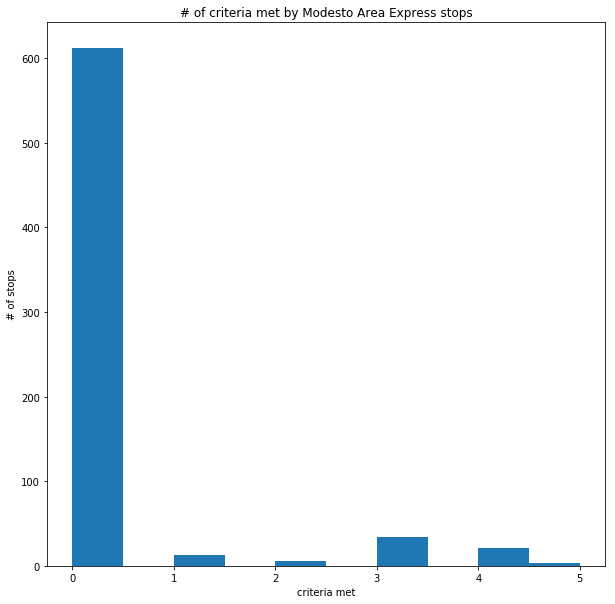

In [511]:
# try to figure out where the non-qualifying stops come from

stop_scores = []

for x in range(len(output)):
    stop_score = 0
    for option in headway_requirements:
        if output["IB " + option][x] <= headway_requirements[option] or output["OB " + option][x] <= headway_requirements[option]:
            stop_score += 1
    stop_scores.append(stop_score)

plt.clf()
plt.figure(figsize=(10,10))

title_text = "# of criteria met by %s stops" % agency_name
plt.title(title_text)

plt.ylabel("# of stops")
plt.xlabel("criteria met")

plt.hist(stop_scores, align='mid')
plt.show()

In [512]:
# add the "score" for each stop
output['stop_scores'] = stop_scores

# create a dictionary of the number of each score for logging
stop_score_dict = dict(output['stop_scores'].value_counts())
for score in [0,1,2,3,4,5]:
    if score not in stop_score_dict:
        stop_score_dict[score] = 0

In [513]:
colorDict = {0: 'k', 1: 'b', 2: 'g', 3: 'y', 4: 'm', 5: 'r'}

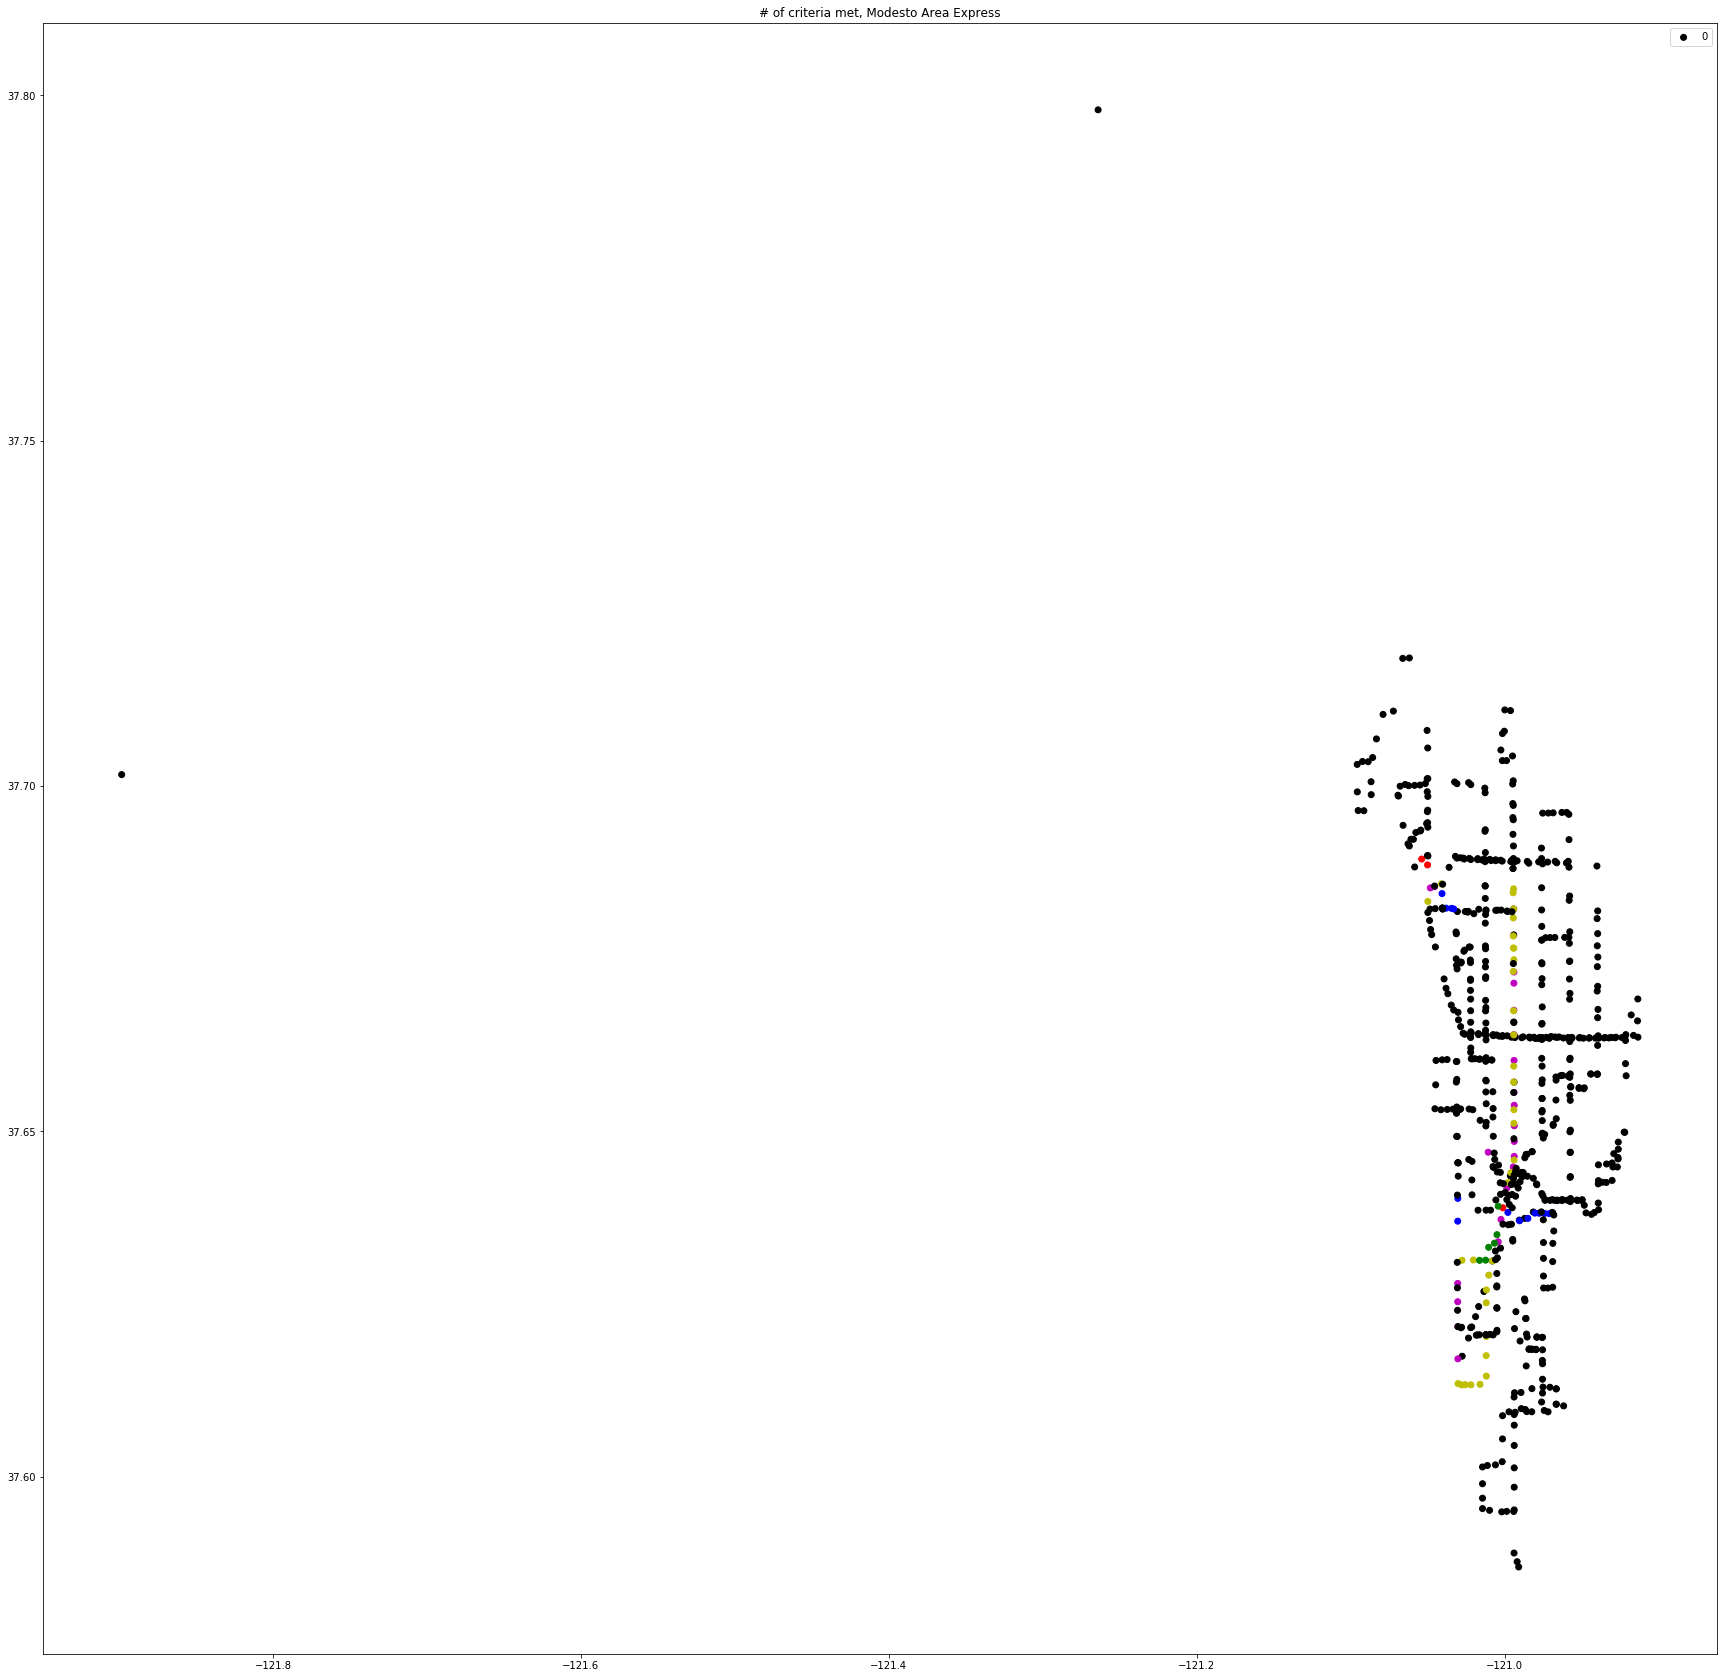

In [514]:
plt.clf()

plt.figure(figsize=(30,30))


plt.scatter(output['X'], output['Y'], c=[colorDict[x] for x in stop_scores])
plt.legend(["0", "1", "2", "3", "4", "5"])

scatter_title = "# of criteria met, %s" %  agency_name
plt.title(scatter_title)

plt.show()

Text(0.5,1,'Stops Meeting Criteria, Modesto Area Express')

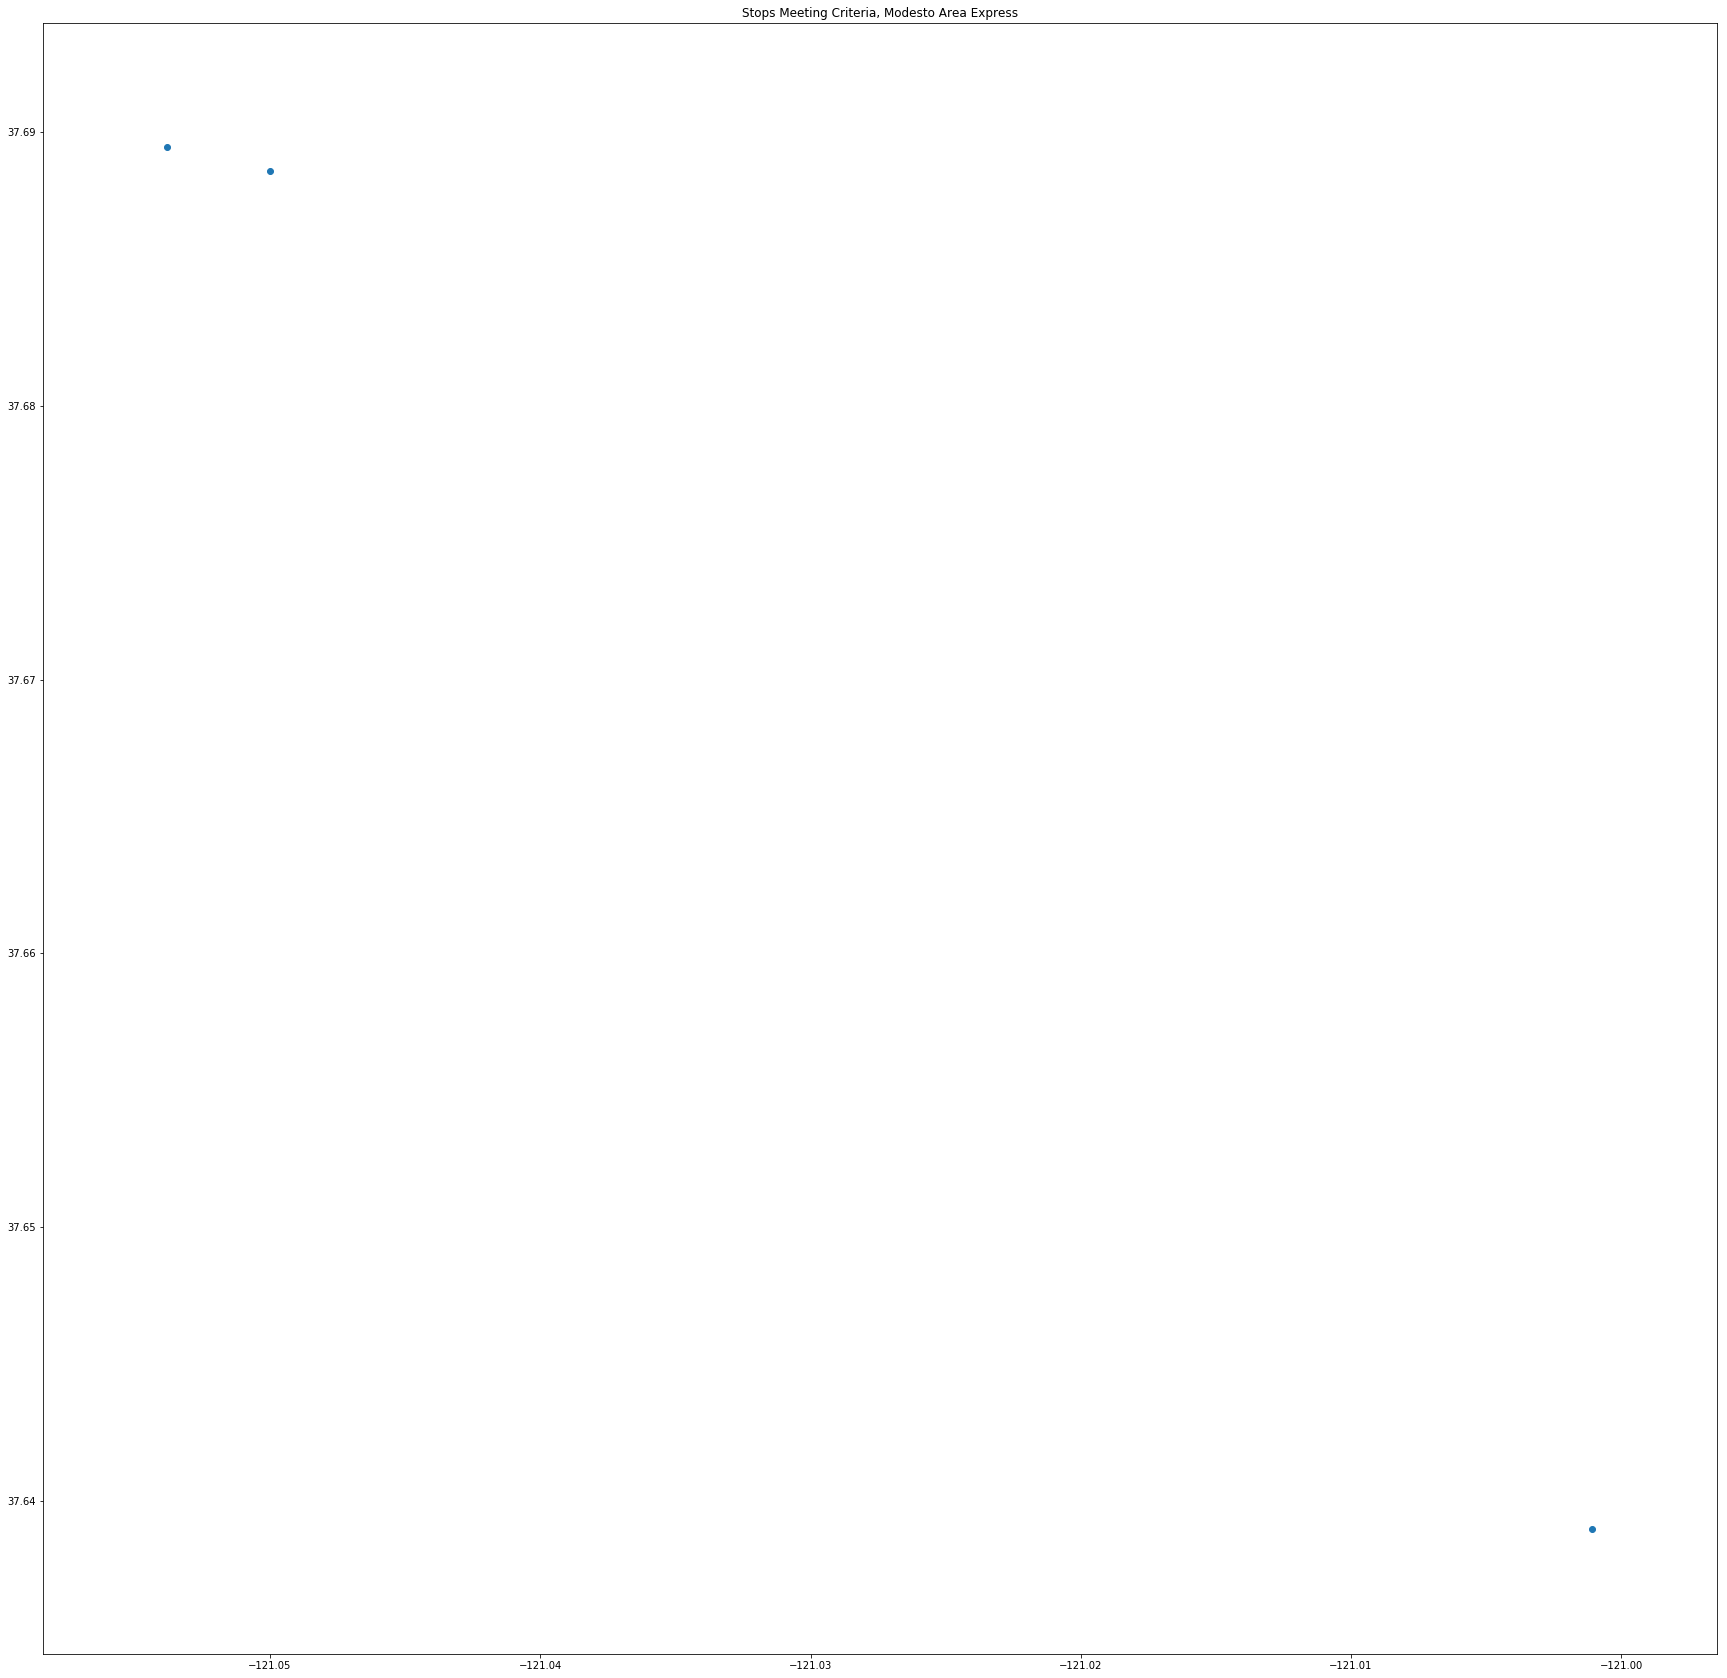

In [515]:
# plot qualifying stops

plt.clf()
plt.figure(figsize=(30,30))
plt.scatter(output[output['stop_scores'] == 5]['X'], output[output['stop_scores'] == 5]['Y'])
#plt.legend(["0", "1", "2", "3", "4", "5"])

scatter_title = "Stops Meeting Criteria, %s" %  agency_name
plt.title(scatter_title)


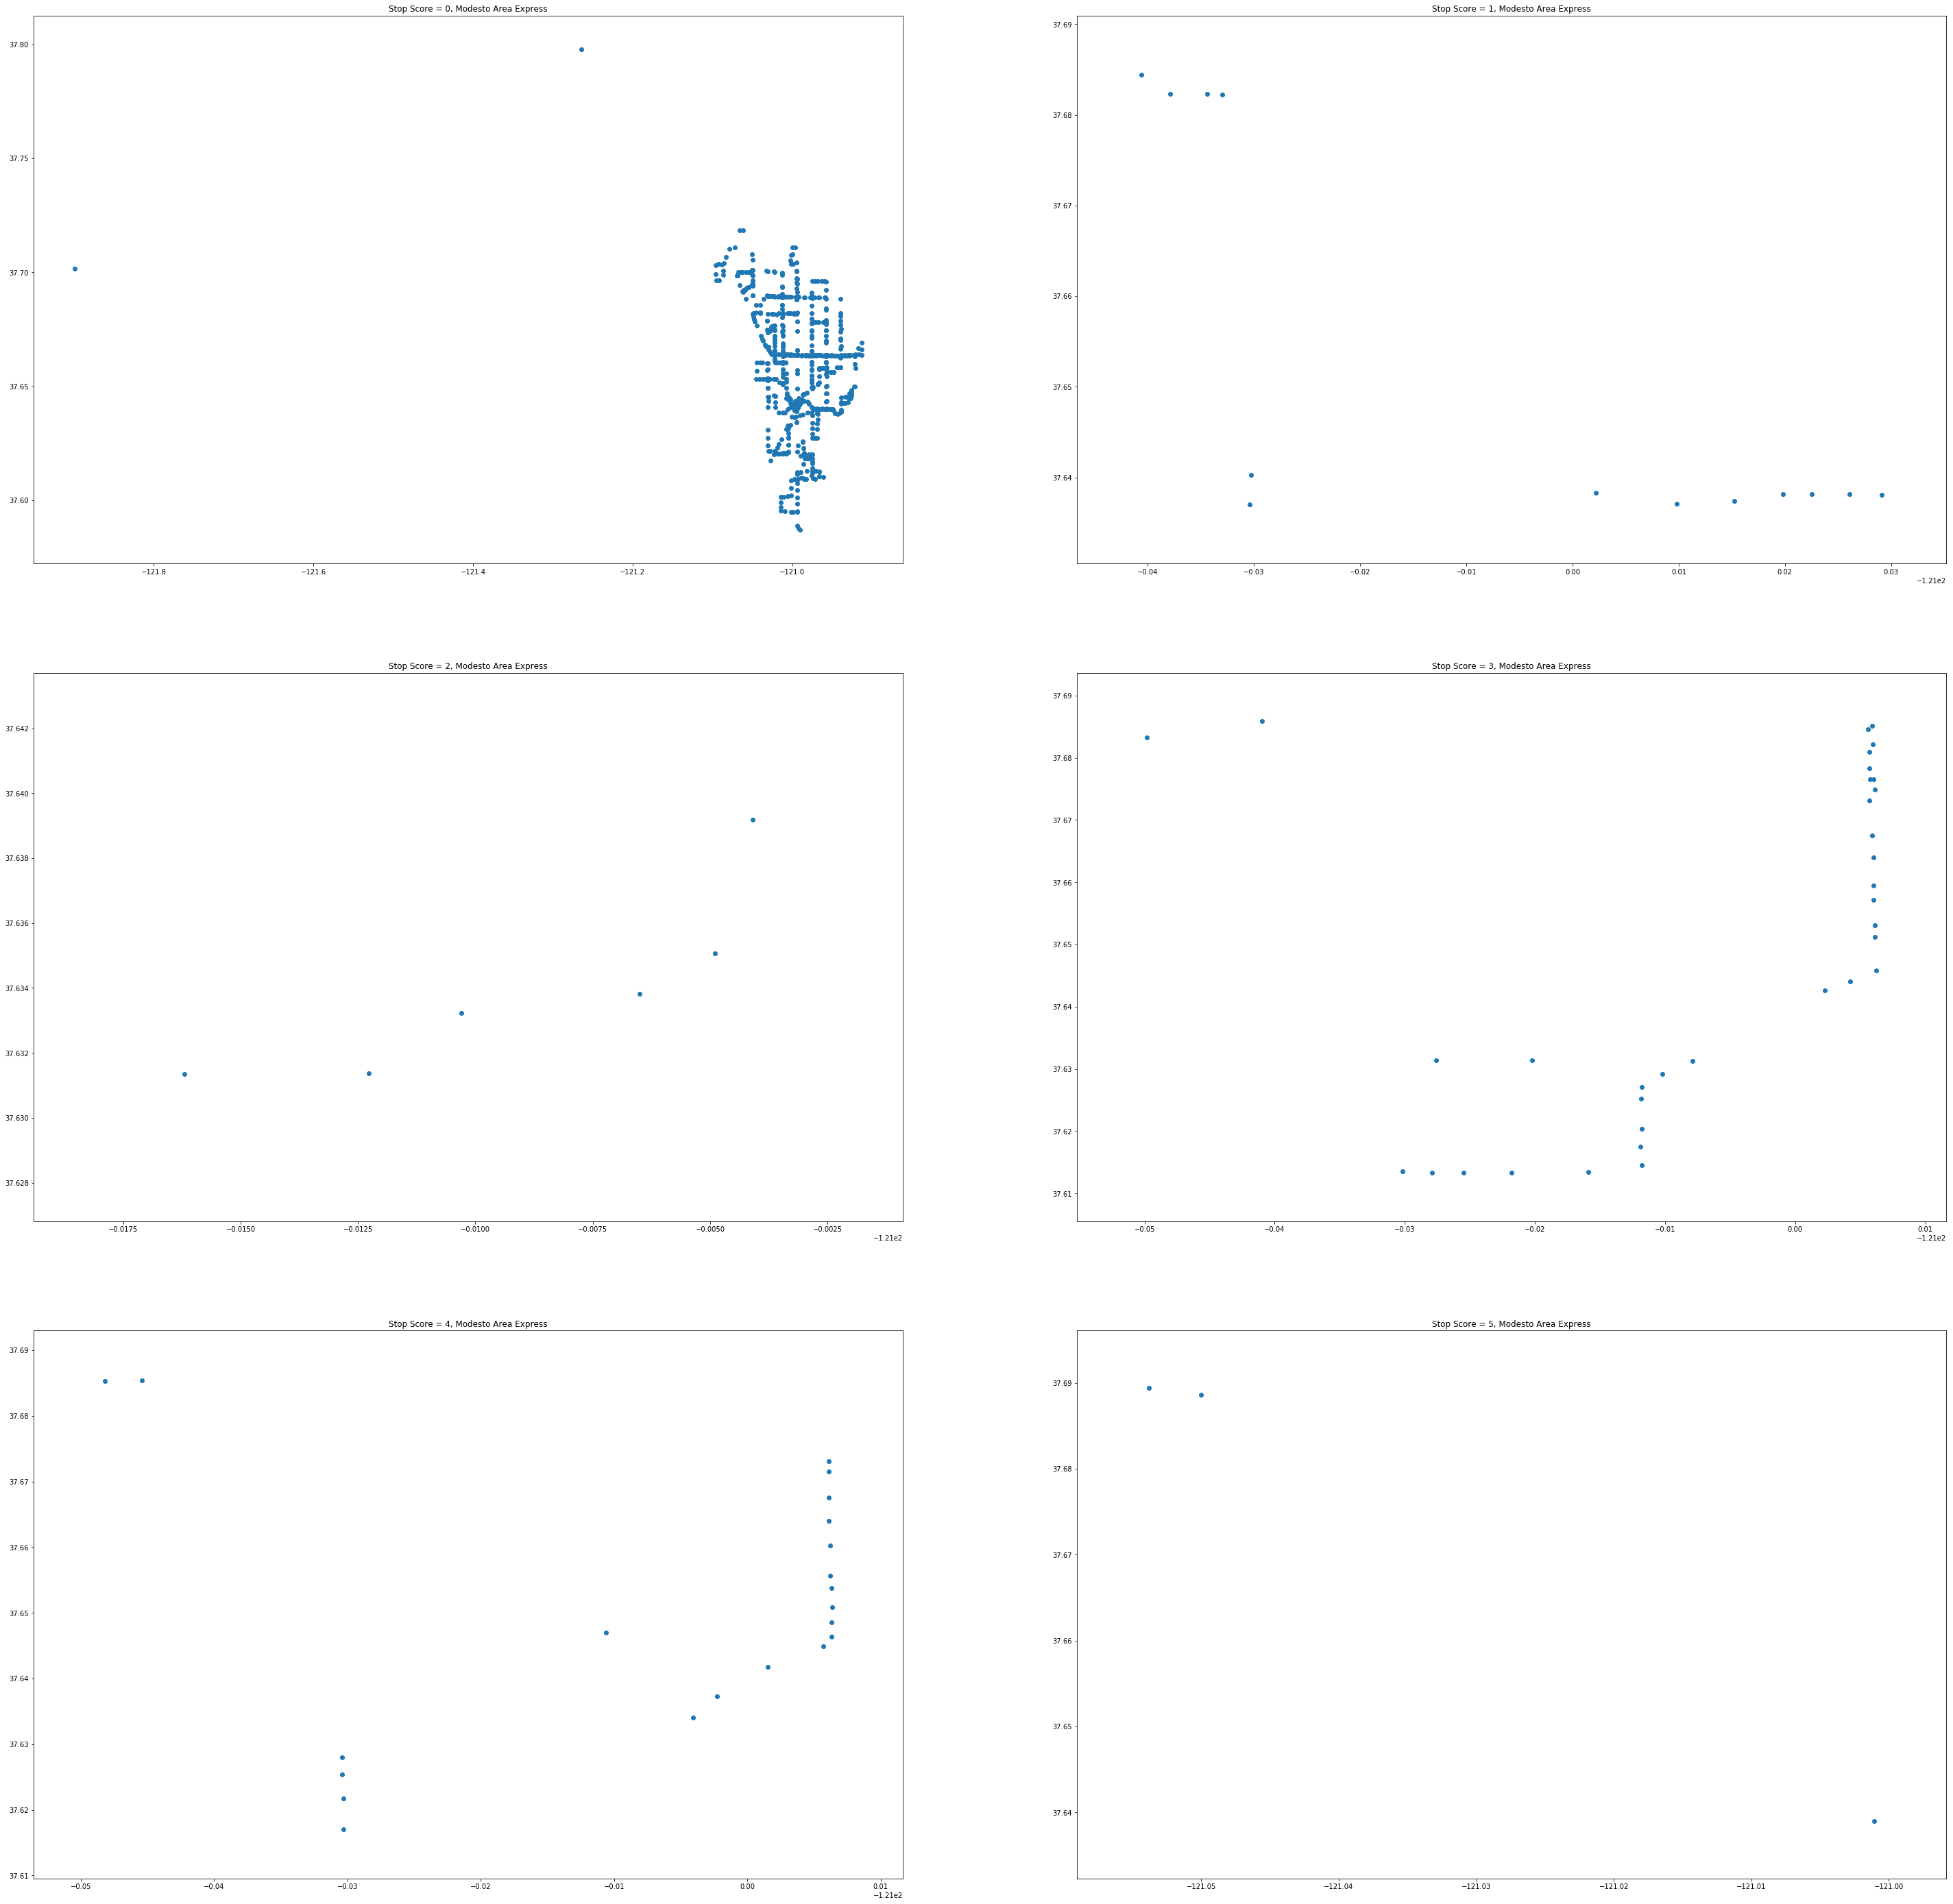

In [516]:
# plot various stops based on their stop_scores

plt.clf()
plt.figure(figsize=(50,50))

for i in range(6):
    subplot = "32" + str(i+1)
    plt.subplot(subplot)
    
    plt.scatter(output[output['stop_scores'] == i]['X'], output[output['stop_scores'] == i]['Y'])


    scatter_title = "Stop Score = %s, %s" %  (i, agency_name)
    plt.title(scatter_title)


In [517]:
# writes some summary values of this agency to a logging csv kept locally

with open(r'output/log.csv', 'a') as log:
    logwriter = csv.writer(log)
    logwriter.writerow([agency_name, str(datetime.datetime.now()), num_of_stops, len(ghost_stops), did_i_interp, stop_score_dict[5], stop_score_dict[4], stop_score_dict[3], stop_score_dict[2], stop_score_dict[1], stop_score_dict[0]])
log.close()

### true misc
things I may come back to

In [518]:
calendar

,service_id,service_name,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,c_6130_b_6542_d_64,Year Round (Sunday only),0,0,0,0,0,0,1,20180201,20190101
1,c_6130_b_6542_d_32,Year Round (Saturday only),0,0,0,0,0,1,0,20180201,20190101
2,c_6130_b_6542_d_31,Year Round (Monday-Friday),1,1,1,1,1,0,0,20180201,20190101


In [519]:
routes

,agency_id,route_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color,route_sort_order,min_headway_minutes,eligibility_restricted
0,95,383,21.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,0099ff,ffffff,0,15.0,0
1,95,386,22.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,cc6633,000000,1,30.0,0
2,95,394,32.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,669900,000000,10,30.0,0
3,95,395,33.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,ff0000,ffffff,11,30.0,0
4,95,397,36.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,999999,000000,12,60.0,0
5,95,398,37.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,999999,000000,13,60.0,0
6,95,399,38.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,cc99ff,000000,14,30.0,0
7,95,401,41.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,669900,000000,15,30.0,0
8,95,402,42.0,NaN,NaN,3,http://www.modestoareaexpress.com/routes/route...,0099ff,000000,16,30.0,0
9,95,405,NaN,MAX / ACE,NaN,3,http://www.modestoareaexpress.com/routes/ace.aspx,ffffff,000000,17,NaN,0


In [520]:
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,...,start_service_area_id,end_service_area_id,start_service_area_radius,end_service_area_radius,continuous_pickup,continuous_drop_off,interpolated,direction_id,service_id,route_type
0,t_204594_b_6542_tn_0,17:30:00,17:30:00,13336,1,NaN,0,0,0.000000,0,...,NaN,NaN,NaN,NaN,1,1,1050.0,1.0,c_6130_b_6542_d_31,3
1,t_204594_b_6542_tn_0,19:00:00,19:00:00,13359,2,NaN,0,0,83305.902540,0,...,NaN,NaN,NaN,NaN,1,1,1140.0,1.0,c_6130_b_6542_d_31,3
2,t_204594_b_6542_tn_0,19:10:00,19:10:00,12550,3,NaN,0,0,89805.115748,0,...,NaN,NaN,NaN,NaN,1,1,1150.0,1.0,c_6130_b_6542_d_31,3
3,t_204595_b_6542_tn_0,18:30:00,18:30:00,13336,1,NaN,0,0,0.000000,0,...,NaN,NaN,NaN,NaN,1,1,1110.0,1.0,c_6130_b_6542_d_31,3
4,t_204595_b_6542_tn_0,20:00:00,20:00:00,13359,2,NaN,0,0,83305.902540,0,...,NaN,NaN,NaN,NaN,1,1,1200.0,1.0,c_6130_b_6542_d_31,3


In [521]:
stop_times[['stop_id', 'arrival_time', 'interpolated']].sort_values("interpolated")

,stop_id,arrival_time,interpolated
316,12550,03:30:00,210.0
317,13338,04:00:00,240.0
318,13337,04:30:00,270.0
41287,13337,04:39:00,279.0
35584,12550,04:45:00,285.0
35585,13359,05:00:00,300.0
41288,13338,05:04:00,304.0
312,13338,05:15:00,315.0
20360,12550,05:45:00,345.0
7297,12550,05:45:00,345.0


In [522]:
# THE INTERPOLATOR IS BROKEN

tempDF = stop_times[stop_times['trip_id'] == stop_times['trip_id'][0]]

test_interp = [minSinceMidnight(x) for x in tempDF['arrival_time']]
tempDF['test_interp'] = test_interp

tempDF[['trip_id','arrival_time', 'interpolated', 'test_interp']]

/Users/mapsense-simon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,trip_id,arrival_time,interpolated,test_interp
0,t_204594_b_6542_tn_0,17:30:00,1050.0,1050.0
1,t_204594_b_6542_tn_0,19:00:00,1140.0,1140.0
2,t_204594_b_6542_tn_0,19:10:00,1150.0,1150.0


In [523]:
agency_trips

['t_204594_b_6542_tn_0',
 't_204595_b_6542_tn_0',
 't_204598_b_6542_tn_1',
 't_204598_b_6542_tn_10',
 't_204598_b_6542_tn_11',
 't_204598_b_6542_tn_12',
 't_204598_b_6542_tn_13',
 't_204598_b_6542_tn_14',
 't_204598_b_6542_tn_15',
 't_204598_b_6542_tn_16',
 't_204598_b_6542_tn_2',
 't_204598_b_6542_tn_3',
 't_204598_b_6542_tn_4',
 't_204598_b_6542_tn_5',
 't_204598_b_6542_tn_6',
 't_204598_b_6542_tn_7',
 't_204598_b_6542_tn_8',
 't_204598_b_6542_tn_9',
 't_204603_b_6542_tn_0',
 't_204605_b_6542_tn_0',
 't_204606_b_6542_tn_0',
 't_204607_b_6542_tn_0',
 't_204609_b_6542_tn_1',
 't_204609_b_6542_tn_10',
 't_204609_b_6542_tn_11',
 't_204609_b_6542_tn_12',
 't_204609_b_6542_tn_13',
 't_204609_b_6542_tn_14',
 't_204609_b_6542_tn_15',
 't_204609_b_6542_tn_16',
 't_204609_b_6542_tn_17',
 't_204609_b_6542_tn_18',
 't_204609_b_6542_tn_19',
 't_204609_b_6542_tn_2',
 't_204609_b_6542_tn_20',
 't_204609_b_6542_tn_21',
 't_204609_b_6542_tn_22',
 't_204609_b_6542_tn_23',
 't_204609_b_6542_tn_3',
 't_

In [524]:
set(list(stop_times['trip_id']))

{'t_204667_b_6542_tn_19',
 't_204686_b_6542_tn_1',
 't_204659_b_6542_tn_23',
 't_204678_b_6542_tn_1',
 't_204691_b_6542_tn_24',
 't_204686_b_6542_tn_23',
 't_204663_b_6542_tn_9',
 't_204696_b_6542_tn_17',
 't_204613_b_6542_tn_9',
 't_204975_b_6542_tn_3',
 't_204714_b_6542_tn_12',
 't_204633_b_6542_tn_5',
 't_204775_b_6542_tn_3',
 't_204640_b_6542_tn_10',
 't_204628_b_6542_tn_2',
 't_204656_b_6542_tn_13',
 't_204666_b_6542_tn_20',
 't_204697_b_6542_tn_2',
 't_204975_b_6542_tn_9',
 't_204641_b_6542_tn_5',
 't_204659_b_6542_tn_1',
 't_204623_b_6542_tn_3',
 't_204633_b_6542_tn_27',
 't_204667_b_6542_tn_15',
 't_204660_b_6542_tn_2',
 't_204673_b_6542_tn_6',
 't_204652_b_6542_tn_9',
 't_204666_b_6542_tn_10',
 't_204613_b_6542_tn_26',
 't_204697_b_6542_tn_19',
 't_204666_b_6542_tn_9',
 't_204695_b_6542_tn_8',
 't_204777_b_6542_tn_2',
 't_204681_b_6542_tn_17',
 't_205092_b_6542_tn_0',
 't_204656_b_6542_tn_6',
 't_204777_b_6542_tn_1',
 't_204609_b_6542_tn_22',
 't_204713_b_6542_tn_10',
 't_2046

In [525]:
list(stop_times.drop_duplicates('trip_id')['trip_id'])

['t_204594_b_6542_tn_0',
 't_204595_b_6542_tn_0',
 't_204598_b_6542_tn_1',
 't_204598_b_6542_tn_10',
 't_204598_b_6542_tn_11',
 't_204598_b_6542_tn_12',
 't_204598_b_6542_tn_13',
 't_204598_b_6542_tn_14',
 't_204598_b_6542_tn_15',
 't_204598_b_6542_tn_16',
 't_204598_b_6542_tn_2',
 't_204598_b_6542_tn_3',
 't_204598_b_6542_tn_4',
 't_204598_b_6542_tn_5',
 't_204598_b_6542_tn_6',
 't_204598_b_6542_tn_7',
 't_204598_b_6542_tn_8',
 't_204598_b_6542_tn_9',
 't_204603_b_6542_tn_0',
 't_204605_b_6542_tn_0',
 't_204606_b_6542_tn_0',
 't_204607_b_6542_tn_0',
 't_204609_b_6542_tn_1',
 't_204609_b_6542_tn_10',
 't_204609_b_6542_tn_11',
 't_204609_b_6542_tn_12',
 't_204609_b_6542_tn_13',
 't_204609_b_6542_tn_14',
 't_204609_b_6542_tn_15',
 't_204609_b_6542_tn_16',
 't_204609_b_6542_tn_17',
 't_204609_b_6542_tn_18',
 't_204609_b_6542_tn_19',
 't_204609_b_6542_tn_2',
 't_204609_b_6542_tn_20',
 't_204609_b_6542_tn_21',
 't_204609_b_6542_tn_22',
 't_204609_b_6542_tn_23',
 't_204609_b_6542_tn_3',
 't_

In [526]:
days_of_week = {0:"monday", 1:"tuesday", 2:"wednesday", 3:"thursday", 4:"friday", 5:"saturday", 6:"sunday"}

In [527]:
weekday

'20180918'

In [528]:
weekday[4:6]

'09'

In [529]:
datetime.datetime(int(weekday[:4]), int(weekday[4:6]), int(weekday[6:])).weekday()

1

In [530]:
'''
GUTS OF INTERPOLATOR



trip_id = stop_times['trip_id'][400]
tempDF = stop_times[stop_times['trip_id'] == trip_id]

arrivalTimes = [minSinceMidnight(x) for x in list(tempDF['arrival_time'])]

last_scheduled_time = arrivalTimes[0]
lst_index = 0

values = [last_scheduled_time]

for x in arrivalTimes[1:]:
    if pd.isnull(x) == False:
        idx = arrivalTimes.index(x)
        yy = list(np.linspace(last_scheduled_time, x, num=(idx-lst_index+1)))
        
        values += yy[1:]
        last_scheduled_time = x
        lst_index = idx
    else:
        pass
'''

"\nGUTS OF INTERPOLATOR\n\n\n\ntrip_id = stop_times['trip_id'][400]\ntempDF = stop_times[stop_times['trip_id'] == trip_id]\n\narrivalTimes = [minSinceMidnight(x) for x in list(tempDF['arrival_time'])]\n\nlast_scheduled_time = arrivalTimes[0]\nlst_index = 0\n\nvalues = [last_scheduled_time]\n\nfor x in arrivalTimes[1:]:\n    if pd.isnull(x) == False:\n        idx = arrivalTimes.index(x)\n        yy = list(np.linspace(last_scheduled_time, x, num=(idx-lst_index+1)))\n        \n        values += yy[1:]\n        last_scheduled_time = x\n        lst_index = idx\n    else:\n        pass\n"

In [531]:
# DETERMINE THE MOST COMMON SCHEDULES
# going to phase this out to account for all schedules
'''

pct_service = dict(trips['service_id'].value_counts()/len(trips))


weekday_query = "monday == 1 & tuesday == 1 & wednesday == 1 & thursday == 1 & friday == 1 & saturday == 0 & sunday == 0"
saturday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 1 & sunday == 0"
sunday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 0 & sunday == 1"

weekday_service = list(calendar.query(weekday_query)['service_id'])
saturday_service = list(calendar.query(saturday_query)['service_id'])
sunday_service = list(calendar.query(sunday_query)['service_id'])

del weekday_query, saturday_query, sunday_query # don't need these anymore



# schedules are stored in an array with an eventual length = 3
schedules = []

# index 0 = weekday
# index 1 = saturday
# index 2 = sunday

for services in [weekday_service, saturday_service, sunday_service]:
    boop = {k:v for (k,v) in pct_service.items() if k in services}
    schedules.append(max(boop, key=boop.get))

schedules # identifies the most common of each service type

'''

'\n\npct_service = dict(trips[\'service_id\'].value_counts()/len(trips))\n\n\nweekday_query = "monday == 1 & tuesday == 1 & wednesday == 1 & thursday == 1 & friday == 1 & saturday == 0 & sunday == 0"\nsaturday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 1 & sunday == 0"\nsunday_query = "monday == 0 & tuesday == 0 & wednesday == 0 & thursday == 0 & friday == 0 & saturday == 0 & sunday == 1"\n\nweekday_service = list(calendar.query(weekday_query)[\'service_id\'])\nsaturday_service = list(calendar.query(saturday_query)[\'service_id\'])\nsunday_service = list(calendar.query(sunday_query)[\'service_id\'])\n\ndel weekday_query, saturday_query, sunday_query # don\'t need these anymore\n\n\n\n# schedules are stored in an array with an eventual length = 3\nschedules = []\n\n# index 0 = weekday\n# index 1 = saturday\n# index 2 = sunday\n\nfor services in [weekday_service, saturday_service, sunday_service]:\n    boop = {k:v for (k,v) in pct_ser

In [532]:
# dates to evaluate
# specified in YYYYMMDD format
'''
weekday_dates = ["20180918"]
saturday_dates = ["20180922"]
sunday_dates = ["20180923"]

for weekday in weekday_dates:
    applicable_weekday_service = [x for x in weekday_service if x not in exceptions[day][2]] + exceptions[day][1]
    
weekday = "20180918"
saturday = "20180922"
sunday = "20180923"

applicable_weekday_service = [x for x in weekday_service if x not in exceptions[weekday][2]] + exceptions[weekday][1]
applicable_saturday_service = [x for x in saturday_service if x not in exceptions[saturday][2]] + exceptions[saturday][1]
applicable_sunday_service = [x for x in sunday_service if x not in exceptions[sunday][2]] + exceptions[sunday][1]
'''

'\nweekday_dates = ["20180918"]\nsaturday_dates = ["20180922"]\nsunday_dates = ["20180923"]\n\nfor weekday in weekday_dates:\n    applicable_weekday_service = [x for x in weekday_service if x not in exceptions[day][2]] + exceptions[day][1]\n    \nweekday = "20180918"\nsaturday = "20180922"\nsunday = "20180923"\n\napplicable_weekday_service = [x for x in weekday_service if x not in exceptions[weekday][2]] + exceptions[weekday][1]\napplicable_saturday_service = [x for x in saturday_service if x not in exceptions[saturday][2]] + exceptions[saturday][1]\napplicable_sunday_service = [x for x in sunday_service if x not in exceptions[sunday][2]] + exceptions[sunday][1]\n'

In [533]:
list((output['IB AM Peak'] + output['IB PM Peak']) <= 30)

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa